<a href="https://colab.research.google.com/github/KatBotkowska/CodersCrew/blob/master/Netflix_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pobranie danych z Kaggle


###https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

##Importy - do przeniesienia z treści niżej

In [ ]:
#podłączenie google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
root_path = 'gdrive/My Drive/netflix/'

In [ ]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kbotkowska","key":"90ebb11108c952959800f5549af3472d"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


##Pobranie i rozpakowanie danych kaggle - netflix

In [ ]:
!kaggle datasets download -d shivamb/netflix-shows

  0% 0.00/971k [00:00<?, ?B/s]
100% 971k/971k [00:00<00:00, 65.4MB/s]


In [ ]:
!unzip -q netflix-shows.zip -d [netflix]

##Pobranie i rozpakowanie danych kaggle - imdb

In [ ]:
!kaggle datasets download -d stefanoleone992/imdb-extensive-dataset

 79% 65.0M/82.3M [00:00<00:00, 67.4MB/s]
100% 82.3M/82.3M [00:00<00:00, 106MB/s] 


In [ ]:
!unzip -q imdb-extensive-dataset.zip -d [netflix]

##Pobranie i rozpakowanie danych kaggle - movielens

In [ ]:
!kaggle datasets download -d grouplens/movielens-20m-dataset

 96% 187M/195M [00:04<00:00, 46.9MB/s]
100% 195M/195M [00:04<00:00, 49.6MB/s]


In [ ]:
!unzip -q movielens-20m-dataset.zip -d [netflix]

##Załadowanie dataframes

In [ ]:
import pandas as pd
netflix_titles = pd.read_csv('/content/[netflix]/netflix_titles.csv')

In [ ]:
imdb_movies = pd.read_csv('/content/[netflix]/IMDb movies.csv')
imdb_names = pd.read_csv('/content/[netflix]/IMDb names.csv')
imdb_ratings = pd.read_csv('/content/[netflix]/IMDb ratings.csv')
imdb_title_principals = pd.read_csv('/content/[netflix]/IMDb title_principals.csv')

NameError: ignored

In [ ]:
movielens_genome_scores = pd.read_csv('/content/[netflix]/genome_scores.csv')
movielens_genome_tags = pd.read_csv('/content/[netflix]/genome_tags.csv')
movielens_link = pd.read_csv('/content/[netflix]/link.csv')
movielens_movie = pd.read_csv('/content/[netflix]/movie.csv')
movielens_rating = pd.read_csv('/content/[netflix]/rating.csv')
movielens_tag = pd.read_csv('/content/[netflix]/tag.csv')

##Czyszczenie danych
zamiana wiersza z TV movie 2019 na 2019
dtypes z object na właściwe
NaN??
gatunki zamiana ze stringa na listy tagów


#Netflix - podstawowe dane


In [ ]:
netflix_titles.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...


In [ ]:
netflix_titles.shape
#rozmiary  - wiersze i kolumny

(6234, 12)

In [ ]:
netflix_titles.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   int64 
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      4265 non-null   object
 4   cast          5664 non-null   object
 5   country       5758 non-null   object
 6   date_added    6223 non-null   object
 7   release_year  6234 non-null   int64 
 8   rating        6224 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


In [ ]:
netflix_titles.describe()
#trochę bez sensu, nie ma tutaj dużo danych numerycznych do podsumowań

,show_id,release_year
count,6.234000e+03,6234.00000
mean,7.670368e+07,2013.35932
std,1.094296e+07,8.81162
min,2.477470e+05,1925.00000
25%,8.003580e+07,2013.00000
50%,8.016337e+07,2016.00000
75%,8.024489e+07,2018.00000
max,8.123573e+07,2020.00000


##Netflix dla 2019

In [ ]:
netflix_2019 = netflix_titles.iloc[:,:][netflix_titles.release_year==2019]
netflix_2019.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
34,80221550,TV Show,Archibald's Next Big Thing,NaN,"Tony Hale, Rosamund Pike, Jordan Fisher, Chels...",NaN,"September 6, 2019",2019,TV-Y7,1 Season,"Kids' TV, TV Comedies",Happy-go-lucky chicken Archibald may not remem...
35,81154455,Movie,Article 15,Anubhav Sinha,"Ayushmann Khurrana, Nassar, Manoj Pahwa, Kumud...",India,"September 6, 2019",2019,TV-MA,125 min,"Dramas, International Movies, Thrillers",The grim realities of caste discrimination com...
38,81132437,Movie,Kill Me If You Dare,Şenol Sönmez,"Murat Boz, Seda Bakan, Açelya Topaloğlu, Özgür...",NaN,"September 6, 2019",2019,TV-14,100 min,"Comedies, International Movies, Romantic Movies","Bogged down with money problems, a couple grow..."
39,80178151,TV Show,The Spy,NaN,"Sacha Baron Cohen, Noah Emmerich, Hadar Ratzon...",France,"September 6, 2019",2019,TV-MA,1 Season,"International TV Shows, TV Dramas, TV Thrillers","In the 1960s, Israeli clerk-turned-secret agen..."


In [ ]:
netflix_2019.shape

(843, 12)

In [ ]:
imdb_movies.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


##IMDB dla 2019

In [ ]:
imdb_2019 = imdb_movies.iloc[:,:][imdb_movies.year==2019]
imdb_2019.head()

NameError: ignored

##Łączenie IMDB i Netflix dla 2019

In [ ]:
netflix_imdb_2019 = pd.merge(netflix_2019, imdb_2019, on=['title'])
netflix_imdb_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23 entries, 0 to 22
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   show_id                23 non-null     int64  
 1   type                   23 non-null     object 
 2   title                  23 non-null     object 
 3   director_x             22 non-null     object 
 4   cast                   23 non-null     object 
 5   country_x              22 non-null     object 
 6   date_added             23 non-null     object 
 7   release_year           23 non-null     int64  
 8   rating                 23 non-null     object 
 9   duration_x             23 non-null     object 
 10  listed_in              23 non-null     object 
 11  description_x          23 non-null     object 
 12  imdb_title_id          23 non-null     object 
 13  original_title         23 non-null     object 
 14  year                   23 non-null     object 
 15  date_pub

In [ ]:
netflix_imdb_2019.shape

(23, 33)

In [ ]:
netflix_imdb_2019

##Łączenie IMDB i Netflix dla wszystkich danych

In [ ]:
netflix_imdb_all = pd.merge(netflix_titles, imdb_movies, on=['title'])
netflix_imdb_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2332 entries, 0 to 2331
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   show_id                2332 non-null   int64  
 1   type                   2332 non-null   object 
 2   title                  2332 non-null   object 
 3   director_x             2026 non-null   object 
 4   cast                   2283 non-null   object 
 5   country_x              2278 non-null   object 
 6   date_added             2330 non-null   object 
 7   release_year           2332 non-null   int64  
 8   rating                 2331 non-null   object 
 9   duration_x             2332 non-null   object 
 10  listed_in              2332 non-null   object 
 11  description_x          2332 non-null   object 
 12  imdb_title_id          2332 non-null   object 
 13  original_title         2332 non-null   object 
 14  year                   2332 non-null   object 
 15  date

In [ ]:
netflix_imdb_all.head()

,show_id,type,title,director_x,cast,country_x,date_added,release_year,rating,duration_x,listed_in,description_x,imdb_title_id,original_title,year,date_published,genre,duration_y,country_y,language,director_y,writer,production_company,actors,description_y,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,tt9428190,Norm of the North: King Sized Adventure,2019,2019-08-02,"Animation, Adventure, Comedy",90,"USA, India, South Korea, China",English,"Richard Finn, Tim Maltby",Dean Stefan,Assemblage,"Alan Marriott, Andrew Toth, Brian Dobson, Cole...",An ancient Chinese artifact has been stolen by...,3.2,284,NaN,NaN,$ 1505059,NaN,13.0,4.0
1,70304989,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada","September 8, 2017",2014,R,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...",tt1971325,Autómata,2014,2015-02-26,"Action, Drama, Sci-Fi",109,"Spain, Bulgaria",English,Gabe Ibáñez,"Gabe Ibáñez, Igor Legarreta",Green Moon,"Antonio Banderas, Dylan McDermott, Melanie Gri...",Human race is at edge of the end. Robot race i...,6.1,53583,$ 7000000,NaN,$ 6237990,37.0,176.0,151.0
2,70304989,Movie,Automata,Gabe Ibáñez,"Antonio Banderas, Dylan McDermott, Melanie Gri...","Bulgaria, United States, Spain, Canada","September 8, 2017",2014,R,110 min,"International Movies, Sci-Fi & Fantasy, Thrillers","In a dystopian future, an insurance adjuster f...",tt8339704,Automata,2019,2020-01-27,Horror,95,UK,English,Lawrie Brewster,Sarah Daly,Hex Studios,"Jamie Scott Gordon, Jonathan Hansler, Alexandr...",Antique expert Brendon Cole is sent to authent...,4.3,314,NaN,NaN,NaN,NaN,39.0,5.0
3,70304990,Movie,Good People,Henrik Ruben Genz,"James Franco, Kate Hudson, Tom Wilkinson, Omar...","United States, United Kingdom, Denmark, Sweden","September 8, 2017",2014,R,90 min,"Action & Adventure, Thrillers",A struggling couple can't believe their luck w...,tt1361318,Good People,2014,2015-08-21,"Action, Crime, Thriller",90,"USA, UK, Denmark, Sweden",English,Henrik Ruben Genz,"Marcus Sakey, Kelly Masterson",Millennium Films,"Sam Spruell, Michael Fox, Diarmaid Murtagh, Fr...",Discovering a stash of cash in their dead tena...,5.5,15257,NaN,NaN,$ 1857574,42.0,56.0,57.0
4,80057969,Movie,Love,Gaspar Noé,"Karl Glusman, Klara Kristin, Aomi Muyock, Ugo ...","France, Belgium","September 8, 2017",2015,NR,135 min,"Cult Movies, Dramas, Independent Movies",A man in an unsatisfying marriage recalls the ...,tt0392360,Love,1991,1991-11-15,"Drama, Musical, Romance",152,India,Hindi,Suresh Krishna,NaN,NaN,"Salman Khan, Revathi, Rita Bhaduri, Shafi Inam...",Prithvi and Maggie fall in love and decide to ...,5.7,1003,NaN,NaN,NaN,NaN,6.0,NaN


In [ ]:
imdb_movies.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

# Szeregi czasowe - jak przez lata zmieniała się liczba wydawanych filmów? - Ewa

In [ ]:
import pandas as pd
imdb_movies = pd.read_csv('/content/[netflix]/IMDb movies.csv')

imdb_movies.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,"Urban Gad, Gebhard Schätzler-Perasini",Fotorama,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",Dante Alighieri,Milano Film,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


In [ ]:
imdb_movies.dtypes

imdb_title_id             object
title                     object
original_title            object
year                      object
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
actors                    object
description               object
avg_vote                 float64
votes                      int64
budget                    object
usa_gross_income          object
worlwide_gross_income     object
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
dtype: object

In [ ]:
imdb_movies.groupby('year').imdb_title_id.count()

year
1894                1
1906                1
1911                5
1912                5
1913               13
                 ... 
2017             3223
2018             3182
2019             2168
2020              401
TV Movie 2019       1
Name: imdb_title_id, Length: 168, dtype: int64

In [ ]:
imdb_movies[imdb_movies.year == 'TV Movie 2019']

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
83917,tt8206668,Bad Education,Bad Education,TV Movie 2019,TV Movie 2019,"Biography, Comedy, Crime",108,USA,English,Cory Finley,"Mike Makowsky, Robert Kolker",HBO Films,"Hugh Jackman, Ray Romano, Welker White, Alliso...",The beloved superintendent of New York's Rosly...,7.1,23973,NaN,NaN,NaN,79.0,135.0,98.0


In [ ]:
imdb_movies.loc[83917, 'year'] = 2019
imdb_movies.year = imdb_movies.year.astype('int')
imdb_movies.dtypes

imdb_title_id             object
title                     object
original_title            object
year                       int64
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
writer                    object
production_company        object
actors                    object
description               object
avg_vote                 float64
votes                      int64
budget                    object
usa_gross_income          object
worlwide_gross_income     object
metascore                float64
reviews_from_users       float64
reviews_from_critics     float64
dtype: object

In [ ]:
data_year_plot = imdb_movies.groupby('year').imdb_title_id.count()
data_year_plot

year
1894       1
1906       1
1911       5
1912       5
1913      13
        ... 
2016    3138
2017    3329
2018    3257
2019    2842
2020     789
Name: imdb_title_id, Length: 112, dtype: int64

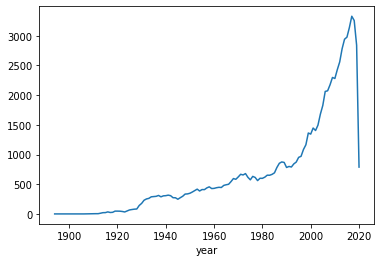

In [ ]:
import matplotlib.pyplot as plt

data_year_plot.plot()
plt.show()

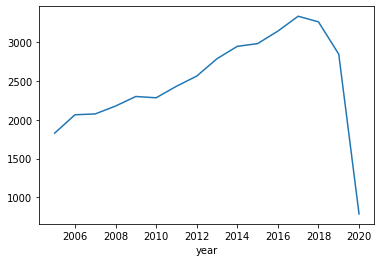

In [ ]:
data_year_plot_from2004 = imdb_movies[imdb_movies.year > 2004].groupby('year').imdb_title_id.count()
data_year_plot_from2004.plot()

# chyba nie ma sensu brać do analizy roku 2020. zastanawiam się nad 2019 - czy przez covida tak mało, czy też braki danych.

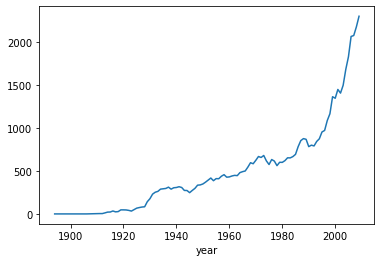

In [ ]:
data_year_plot_to2009 = imdb_movies[imdb_movies.year <= 2009].groupby('year').imdb_title_id.count()
data_year_plot_to2009.plot()

In [ ]:
imdb_movies.loc[83917, 'date_published'] = '2019-01-01' #ustawiam 1 stycznia jako datę publikacji tego dziwnego filmu

pd.to_datetime(imdb_movies['date_published'])

0       1894-10-09
1       1906-12-26
2       1911-08-19
3       1912-11-13
4       1911-03-06
           ...    
85850   2020-01-29
85851   2020-02-13
85852   2019-03-08
85853   2019-03-15
85854   2020-02-05
Name: date_published, Length: 85855, dtype: datetime64[ns]

In [ ]:
imdb_movies['date_published'].dt.year #nie wiem czemu wyskakuje błąd, dkoro wyżej widać, że ta kolumna już jest typem datetime

AttributeError: ignored

#Na lata jakie rodzaje filmów dominują, jakie trendy w gatunkach - KASIA

In [ ]:
import pandas as pd
imdb_movies = pd.read_csv('/content/[netflix]/IMDb movies.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##Najczęściej występujące gatunki

In [ ]:
imdb_movies['genre'].value_counts().head(10)

Drama                     12543
Comedy                     7693
Comedy, Drama              4039
Drama, Romance             3455
Comedy, Romance            2508
Comedy, Drama, Romance     2293
Horror                     2268
Drama, Thriller            1348
Crime, Drama               1343
Action, Crime, Drama       1310
Name: genre, dtype: int64

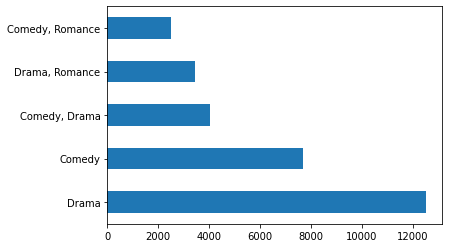

In [ ]:
ax = imdb_movies['genre'].value_counts().head().plot.barh( rot=0)

##Ilość gatunków w poszczególnych latach
Widać, że gatunki to 'tagi' opisujące film, do jednego filmu przypisuje się coraz więcej gatunków.

In [ ]:
#ilość gatunków w poszczególnych latach
imdb_movies.groupby('year').genre.count().tail(20)

year
2002                3
2003                9
2004                7
2005               15
2006               14
2007               23
2008               11
2009               18
2010               24
2011               65
2012              847
2013             1916
2014             2517
2015             2764
2016             2992
2017             3223
2018             3182
2019             2168
2020              401
TV Movie 2019       1
Name: genre, dtype: int64

##Lista wszystkich gatunków

In [ ]:
genres = imdb_movies['genre'].unique().tolist()
genres_all=[]
for genre in genres:
    for elem in genre.split(','):
        genres_all.append(elem.strip())
genres_all=list(set(genres_all))
genres_all

['Western',
 'Animation',
 'Comedy',
 'Musical',
 'Adventure',
 'Action',
 'Thriller',
 'Reality-TV',
 'News',
 'Fantasy',
 'War',
 'Horror',
 'Biography',
 'Romance',
 'Adult',
 'Documentary',
 'Drama',
 'History',
 'Film-Noir',
 'Family',
 'Sport',
 'Mystery',
 'Sci-Fi',
 'Music',
 'Crime']

##Unikalne gatunki - najbardziej popularne

In [ ]:
genres = imdb_movies['genre'].tolist()
genres_count=[]
for genre in genres:
    for elem in genre.split(','):
        genres_all.append(elem.strip())
genres_count=list(genres_all)
from collections import Counter
genres_count_all=pd.DataFrame.from_dict(Counter(genres_count), orient='index')
genres_count_all.rename(columns={'index':'genres', 0:'occurences'}, inplace=True)
genres_count_all.sort_values(by='occurences', ascending=False)


,occurences
Drama,47111
Comedy,29369
Romance,14129
Action,12949
Thriller,11389
Crime,11068
Horror,9558
Adventure,7591
Mystery,5226
Family,3963


Text(0.5, 0, 'occurences')

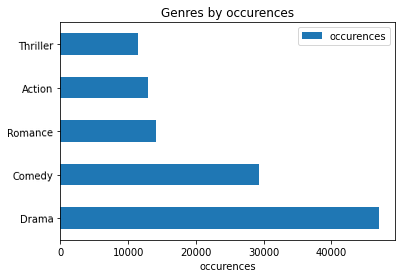

In [ ]:
ax = genres_count_all.sort_values(by='occurences', ascending=False).head().plot.barh(rot=1, title='Genres by occurences')
ax.set_xlabel('occurences')
#ax.set_ylabel()


##Gatunki na lata

In [ ]:
imdb_movies['genre_list']=imdb_movies['genre'].str.split(',', n=5)
#imdb_movies['genre_list'].value_counts().head(10)

In [ ]:
genres_by_years=imdb_movies[['genre', 'year']].groupby(['year', 'genre'], as_index=True)['genre'].count()
genres_by_years.tail(100)

year           genre                     
2020           Adventure, Family              1
               Adventure, Family, Fantasy     3
               Adventure, Horror              1
               Adventure, Romance             1
               Animation                      1
                                             ..
               Sport                          1
               Thriller                      18
               War                            3
               Western                        1
TV Movie 2019  Biography, Comedy, Crime       1
Name: genre, Length: 100, dtype: int64

In [ ]:
#dla roku 2019 zamiana str gatunków na listę
genres_split_by_years=imdb_movies[['genre', 'year', 'imdb_title_id']]
genres_split_by_years[genres_split_by_years['year']=='2019']
genres = genres_split_by_years['genre']

new_genres=[]
for genre in genres.to_list():
    genre = genre.split(',')
    new_genres.append(genre)

genres_split_by_years['new_genre']=new_genres
genres_split_by_years


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,genre,year,imdb_title_id,new_genre
0,Romance,1894,tt0000009,[Romance]
1,"Biography, Crime, Drama",1906,tt0000574,"[Biography, Crime, Drama]"
2,Drama,1911,tt0001892,[Drama]
3,"Drama, History",1912,tt0002101,"[Drama, History]"
4,"Adventure, Drama, Fantasy",1911,tt0002130,"[Adventure, Drama, Fantasy]"
...,...,...,...,...
85850,Comedy,2020,tt9908390,[Comedy]
85851,"Comedy, Drama",2020,tt9911196,"[Comedy, Drama]"
85852,Drama,2019,tt9911774,[Drama]
85853,"Drama, Family",2019,tt9914286,"[Drama, Family]"


In [ ]:
genres_in_2019 = genres_split_by_years[genres_split_by_years['year']=='2019']
genres_2019=genres_in_2019['new_genre'].to_list()
genres_2019

In [ ]:
genres_count=[]
genres_all=[]
for genres in genres_2019:
    for genre in genres:
        genres_all.append(genre)
genres_count_2019=list(genres_all)
from collections import Counter
genres_count_all_2019=pd.DataFrame.from_dict(Counter(genres_count_2019), orient='index')
genres_count_all_2019.rename(columns={'index':'genres', 0:'occurences'}, inplace=True)

genres_count_all_2019.sort_values(by='occurences', ascending=False)

In [ ]:
#Genres by years

table={}
years = ['2010', '2011', '2012','2013','2014','2015','2016', '2017','2018','2019']
genres = ['Drama', 'Comedy', 'Romance', 'Action', 'Thriller','Crime', 'Horror']

for year in years:

    genres_in_year = genres_split_by_years[genres_split_by_years['year']==year]['new_genre']
    genres_in_year=[item.strip() for sublist in genres_in_year for item in sublist]
    table[year]={}
    for genre in genres: ##genres_all nie działa???
        table[year][genre]=genres_in_year.count(genre)

genres_in_years = pd.DataFrame(table)
genres_in_years
   



,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Drama,11,35,425,1043,1344,1511,1623,1752,1669,1175
Comedy,12,22,292,663,887,923,999,1016,1020,661
Romance,3,11,112,310,403,411,409,396,384,223
Action,2,16,120,257,335,409,475,495,476,347
Thriller,4,9,109,318,431,502,548,573,531,407
Crime,2,8,67,169,229,243,304,324,290,230
Horror,2,5,113,249,390,428,432,479,462,315


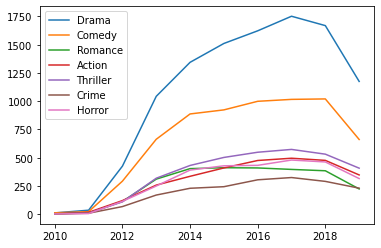

In [ ]:
genres_in_years.T.plot()

# Jakie kraje dominują w produkcji filmów  - które wypuszczają najwięcej filmów, i z 5 największych zrobić szeregi czasowe - GRZESIEK

In [ ]:
import pandas as pd
imdb_movies = pd.read_csv('/content/[netflix]/IMDb movies.csv')